# Import BDTs (& sig/bkg)

This notebook adapts Aditya's code to import pretrained BDTs and run them on signal/background root files to get the predictions/logit. 
Its a test notebook to check that the BDTs can be imported and run on samples to get prediction scores.

In [1]:
import uproot3 as uproot 
import numpy as np
import awkward as ak
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
import joblib

### Importing a BDT to test with

In [2]:
BDT_path = '/exp/uboone/data/users/jbateman/workdir/aadi/jupyter_koto/Booster2sens'
booster = joblib.load(BDT_path+'/Run1_150_MeV_NEW/BDT_models/BDT_Model_Top_14_features_Run1_150_MeVKDIF_1shr_Final_Main_BDT')

/nashome/j/jbateman/miniconda3/envs/HPS_ana/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [09:36:31] WARNING: /workspace/src/common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)
/nashome/j/jbateman/miniconda3/envs/HPS_ana/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [09:36:31] WARNING: /workspace/src/learner.cc:873: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  warnings.warn(smsg, UserWarning)


### Importing raw ntuples/root files

This is not going to result in strictly correct results. The full analysis involves splitting overlay samples into 1/2 reconstructed shower samples.

In [3]:
signal_path = '/pnfs/uboone/persistent/users/anavrera/hpsgen/'
# signal files called "koto_gen_hist_{masspoint}_{kdif/kdar}_{fhc/rhc}_newflux.root"
data = uproot.open(signal_path+'koto_gen_hist_150_kdif_rhc_newflux.root')['generator/event_tree;1']
# df_dataframe = data.arrays(library="pd")

bkg_path = '/exp/uboone/data/users/jbateman/workdir/HPS_uboone_analysis/NewFlux'
bkg_name = 'numi_nu_pelee_ntuples_run3_rhc_g4.10.4_full.root'

bkg = uproot.open(bkg_path+'/'+bkg_name)['nuselection/NeutrinoSelectionFilter;1']

In [4]:
data.keys()

[b'kaon_mom_x',
 b'kaon_mom_y',
 b'kaon_mom_z',
 b'kaon_energy',
 b'kaon_decay_x',
 b'kaon_decay_y',
 b'kaon_decay_z',
 b'kaon_decay_t',
 b'scalar_mom_x',
 b'scalar_mom_y',
 b'scalar_mom_z',
 b'scalar_energy',
 b'scalar_decay_x',
 b'scalar_decay_y',
 b'scalar_decay_z',
 b'scalar_decay_t',
 b'scalar_tau',
 b'scalar_beta',
 b'scalar_gamma',
 b'daughter1_mom_x',
 b'daughter1_mom_y',
 b'daughter1_mom_z',
 b'daughter1_energy',
 b'daughter2_mom_x',
 b'daughter2_mom_y',
 b'daughter2_mom_z',
 b'daughter2_energy',
 b'weight',
 b'flux_weight',
 b'decay_weight',
 b'branching_ratio_weight',
 b'selected',
 b'kaon_pdg',
 b'daughter_pdg',
 b'lambda1',
 b'lambda2',
 b'ctaubetagamma']

In [5]:
Run3 = True
if Run3:
    path = '/exp/uboone/data/users/jbateman/workdir/aadi/generic_koto_numi_fhc_rhc/Final_v51_FHC/'
    cv_path = path+'sfn_numi_fhc_generic_100_ppfx_CV_train.root'
else:
    path = '/exp/uboone/data/users/jbateman/workdir/aadi/generic_koto_numi_fhc_rhc/Final_v51_RHC/'
    cv_path = path+'sfn_numi_rhc_generic_100_ppfx_CV_train.root'

sig = uproot.open(cv_path)['nuselection/NeutrinoSelectionFilter;1']

In [7]:
names = booster.feature_names

names_final = []
for name in names:
    names_final.append(name[:-3])

### Selection cuts

Helpfully aditya stored the selection cuts in a python notebook, Load_booster.ipynb. The function is adapted into a function that queries a pandas dataframe, and the change in sample sizes is logged at each stage. This does NOT consider event weight however. 

In [18]:
# Aditya's selection cuts defined in Load_booster.ipynb

def Selection_mc(df_dataframe,weightTune=True,signalbool=False,print_bool = False):
    
    if weightTune == False:
        in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"
        out_fv_query = "((reco_nu_vtx_sce_x<10 or reco_nu_vtx_sce_x>246) or (reco_nu_vtx_sce_y<-106 or reco_nu_vtx_sce_y>106) or (reco_nu_vtx_sce_z<10 or reco_nu_vtx_sce_z>1026))"
        
    else:
        in_fv_query = "10<=true_nu_vtx_x<=246 and -106<=true_nu_vtx_y<=106 and 10<=true_nu_vtx_z<=1026"
        out_fv_query = "((true_nu_vtx_x<10 or true_nu_vtx_x>246) or (true_nu_vtx_y<-106 or true_nu_vtx_y>106) or (true_nu_vtx_z<10 or true_nu_vtx_z>1026))"

    if signalbool == True:
        in_fv_query = "10<=true_nu_vtx_x<=246 and -106<=true_nu_vtx_y<=106 and 10<=true_nu_vtx_z<=1026"
        out_fv_query = "((true_nu_vtx_x<10 or true_nu_vtx_x>246) or (true_nu_vtx_y<-106 or true_nu_vtx_y>106) or (true_nu_vtx_z<10 or true_nu_vtx_z>1026))"
        
        
    infv = df_dataframe.query(in_fv_query+' and nu_purity_from_pfp>0.5')
    cosmic = df_dataframe.query(in_fv_query+' and nu_purity_from_pfp<=0.5')
    outfv = df_dataframe.query(out_fv_query)
    
    
    
    # check that everything is accounted for 
    if len(df_dataframe)==len(infv)+len(cosmic)+len(outfv):
        if print_bool==True:
            print ('Number of COSMICS ' + str(len(cosmic)))
            print ('Number of Interactions INSIDE FV ' + str(len(infv)))
            print ('Number of Interactions OUTSIDE FV ' + str(len(outfv)))
            print ('Total in DATAFRAME ' + str(len(df_dataframe)))
            print ('Sum of FV + Cosmics + OutFV adds to the MC..')
    else:
        if print_bool==True:
            print ('Number of COSMICS ' + str(len(cosmic)))
            print ('Number of Interactions INSIDE FV ' + str(len(infv)))
            print ('Number of Interactions OUTSIDE FV ' + str(len(outfv)))
            print ('Total in DATAFRAME ' + str(len(df_dataframe)))
            print ('Sum of FV + Cosmics + OutFV DOES NOT add to the MC..')
            print ('Something is wrong...cosmics/outFV/inFV not summing to the original dataframe (Ignore this for Ext and On-Beam)')
            return 0
    
    df_dataframe = infv.copy()
    
    if print_bool==True:
        print ('Before Slice ID cut ' + str(df_dataframe['nslice'].count()))
    df_dataframe = df_dataframe.loc[df_dataframe['nslice'] == 1]
    if print_bool==True:
        print ('After Slice ID cut ' + str(df_dataframe['nslice'].count()))

    if Run3 == True:
        df_dataframe = df_dataframe.loc[df_dataframe['crtveto'] != 1]
        if print_bool==True:
            print ('After CRT VETO cut ' + str(df_dataframe['crtveto'].count()))

    #df_dataframe = df_dataframe.loc[df_dataframe['shr_pfp_id_v'] <= 1000]
    #df_dataframe.query('trk_score_v<0.5 and trk_score_v>=0.0',inplace=True)
    
    df_dataframe = df_dataframe.loc[df_dataframe['trk_score_v'] <= 0.5]
    df_dataframe = df_dataframe.loc[df_dataframe['trk_score_v'] >= 0.0]
    if print_bool==True:
        print ('After Track score cut ' + str(df_dataframe['nslice'].count()))

    df_dataframe.query('n_showers_contained_MCStool==2',inplace=True)
    if print_bool==True:
        print ('After n_showers_contained_MCStool cut ' + str(df_dataframe['nslice'].count()))

    # When will this be not the case. Only when I have the signal cuz it has overlays.
    if weightTune == True:
        print ('Setting weightTune right')
        df_dataframe['weightTune'] = df_dataframe['weightTune'].fillna(1.0)
        df_dataframe.loc[df_dataframe.weightTune > 50, 'weightTune'] = 1.0
        if print_bool==True:
            print (df_dataframe['weightTune'].count())

    # The following is increasing the no. of events. It is as if we are organising the data more correctly by having the following cut.
    # The weird part is that it is chopping just 6 events. How could 6 events give a significant different from 15717 to 14020.
    # Having a cut increases the number of events than having no cut at all WHAT??????????
    # Maybe I would get even more number of events  
    #df_dataframe['shr_pfp_id_v'] = df_dataframe['shr_pfp_id_v'].astype(np.uint64)


    df_dataframe = df_dataframe.loc[df_dataframe['shr_pfp_id_v'] <= 1000]
    if print_bool==True:
        print ('After shr_pfp_id_v cut ' + str(df_dataframe['nslice'].count()))

    df_dataframe["temp_ID"] = df_dataframe["run"].apply(str) +"_"+ df_dataframe["sub"].apply(str) +"_"+ df_dataframe["evt"].apply(str)
    # I think the following removes the single event and keep those that are >=2
    df_dataframe = df_dataframe[df_dataframe.duplicated(['run','sub','evt'], keep=False)]

    df_dataframe['Counts'] = df_dataframe.groupby(['entry'])['temp_ID'].transform('count')
    

    #df_dataframe = df_dataframe.loc[df_dataframe['Counts'] == 2]
    #df_dataframe.query('Counts<=2',inplace=True)
    df_dataframe = df_dataframe.loc[df_dataframe['Counts'] <= 2]
    if print_bool==True:
        print ('After counts<=2 cut................ ' + str(df_dataframe['nslice'].count()))

    df_dataframe = df_dataframe.loc[df_dataframe['Counts'] == 2]
    if print_bool==True:
        print ('After counts==2 cut................ ' + str(df_dataframe['nslice'].count()))

    df_dataframe['leading_shr_hits'] = df_dataframe['pfnhits'].groupby("entry").transform(max) == df_dataframe['pfnhits']

    df_dataframe['leading_shr_energy'] = df_dataframe['shr_energy_y_v'].groupby("entry").transform(max) == df_dataframe['shr_energy_y_v']

    #df_dataframe['leading_shr'] = np.logical_and(df_dataframe['leading_shr_hits'], df_dataframe['leading_shr_energy'])
    df_dataframe.eval('leading_shr = leading_shr_hits',inplace=True)

    #df_dataframe.query('sub == 200')

    #df_dataframe["temp_ID"] = df_dataframe["run"].apply(str) +"_"+ df_dataframe["sub"].apply(str) +"_"+ df_dataframe["evt"].apply(str)
    if print_bool==True:
        print (df_dataframe.query('leading_shr == True')['temp_ID'].nunique())
        print (df_dataframe.query('leading_shr == True')['temp_ID'].count())
        print (df_dataframe.query('leading_shr == False')['temp_ID'].nunique())
        print (df_dataframe.query('leading_shr == False')['temp_ID'].count())


    df_temp = df_dataframe.copy()

    # There must be many true than false as the code is thinking both are leading shr so more trues
    df_temp.query('leading_shr_hits == True',inplace=True)

    # Keep the ones that have both the values == True
    df_temp_temp = df_temp[df_temp.duplicated(subset=['temp_ID'],keep=False)].copy()
    #display (df_temp_temp)
    if print_bool==True:
        print ('Before is above')
    # These two true events must have the same leading_shr_energy for run 3 signal that's why an error
    

    if Run3 == True:
        df_dataframe = df_dataframe[~df_dataframe.temp_ID.isin(df_temp_temp.temp_ID.values)]
    else:
        df_temp_temp.eval('leading_shr = leading_shr_energy',inplace=True)
        #display (df_temp_temp)
        # We usually don't apply the leading shower query and set it inplace to true.
        # We have done this for temp query and seeing what are some of the temp_ids with two true for same event
        df_dataframe.update(df_temp_temp)
    df_dataframe = df_dataframe.drop_duplicates(subset=['temp_ID', 'trk_score_v','shr_px_v','pfnhits'], keep='first')

    if print_bool==True:
        print('leading shower')
        print (df_dataframe.query('leading_shr == True')['temp_ID'].nunique())
        print (df_dataframe.query('leading_shr == True')['temp_ID'].count())
        print (df_dataframe.query('leading_shr == False')['temp_ID'].nunique())
        print (df_dataframe.query('leading_shr == False')['temp_ID'].count())



    df_dataframe_ls = df_dataframe[df_dataframe['leading_shr']==True].copy()

    df_dataframe_sls = df_dataframe[df_dataframe['leading_shr']==False].copy()


    result_df_ls = pd.DataFrame(df_dataframe_ls['evt'].values - df_dataframe_sls['evt'].values)

    if print_bool==True:
        print(result_df_ls.count())
        print(result_df_ls.nunique())

    df_dataframe.index = range(len(df_dataframe['run']))
    return df_dataframe

#frac_change_100_df = fraction_change(common,'pred_100_CV','FHC_100')

In [16]:
# Defining the variables needed for the BDT

variables = [
'nslice','trk_score_v','n_showers_contained_MCStool','shr_pfp_id_v','pfnhits',
'run','sub','evt',
'shr_px_v','shr_py_v','shr_pz_v',
'shr_start_x_v','shr_start_y_v','shr_start_z_v',
'reco_nu_vtx_sce_x','reco_nu_vtx_sce_y','reco_nu_vtx_sce_z',
'shr_energy_y_v','shr_energy_u_v','shr_theta_v','shr_phi_v',
'category','contained_fraction',
'tksh_distance','tksh_angle','n_tracks',
'ccnc','true_nu_vtx_x','true_nu_vtx_y','true_nu_vtx_z',
'shr_hits_y_tot','hits_ratio','nu_purity_from_pfp',
'shr_energy','shr_dist_v', 'shr_pca_0','crtveto',
]

variables += names_final

df_sig = sig.pandas.df(variables,flatten=True, )
df_bkg = bkg.pandas.df(variables,flatten=True, entrystop=1000)

In [19]:
Run3 = True
df_sig_selected = Selection_mc(df_sig, signalbool=True, weightTune=False, print_bool=True) # weightTune=True for Overlay bkg but False for everything else including signal.
df_bkg_selected = Selection_mc(df_bkg, signalbool=False, weightTune=False)

Number of COSMICS 4081
Number of Interactions INSIDE FV 52757
Number of Interactions OUTSIDE FV 7596
Total in DATAFRAME 64434
Sum of FV + Cosmics + OutFV adds to the MC..
Before Slice ID cut 52757
After Slice ID cut 52757
After CRT VETO cut 52757
After Track score cut 33275
After n_showers_contained_MCStool cut 11720
After shr_pfp_id_v cut 11303
After counts<=2 cut................ 10788
After counts==2 cut................ 10788
5394
5399
5389
5389
Before is above
leading shower


/tmp/ipykernel_3025089/2362112602.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dataframe["temp_ID"] = df_dataframe["run"].apply(str) +"_"+ df_dataframe["sub"].apply(str) +"_"+ df_dataframe["evt"].apply(str)
/tmp/ipykernel_3025089/2362112602.py:103: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df_dataframe['leading_shr_hits'] = df_dataframe['pfnhits'].groupby("entry").transform(max) == df_dataframe['pfnhits']
/tmp/ipykernel_3025089/2362112602.py:105: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a

5389
5389
5389
5389
0    5389
dtype: int64
0    1
dtype: int64


In [12]:
# BDT prediction function, given the BDT model and a pandas dataframe. Adapted from Aditya's code.
def booster_pred_df(booster, df):

    df_untrained = df.copy()

    df_untrained_even = df_untrained[df_untrained['leading_shr']==True]
    df_untrained_odd = df_untrained[df_untrained['leading_shr']==False]

    df_untrained['recoDotProduct'] = df_untrained_even['shr_px_v'].mul(df_untrained_odd['shr_px_v'].values) + df_untrained_even['shr_py_v'].mul(df_untrained_odd['shr_py_v'].values) + df_untrained_even['shr_pz_v'].mul(df_untrained_odd['shr_pz_v'].values)
    df_untrained['prod_shr_E_y'] = df_untrained_even['shr_energy_y_v'].mul(df_untrained_odd['shr_energy_y_v'].values)
    df_untrained.eval('recoOpeningAngle = arccos(recoDotProduct)',inplace=True)
    df_untrained.eval('inv_mass = sqrt((2/(0.802*0.802))*prod_shr_E_y*(1-recoDotProduct))',inplace=True)
    df_untrained['dist_bw_showers_x'] = df_untrained_even['shr_start_x_v'].sub(df_untrained_odd['shr_start_x_v'].values)
    df_untrained['dist_bw_showers_y'] = df_untrained_even['shr_start_y_v'].sub(df_untrained_odd['shr_start_y_v'].values)
    df_untrained['dist_bw_showers_z'] = df_untrained_even['shr_start_z_v'].sub(df_untrained_odd['shr_start_z_v'].values)
    df_untrained.eval('dist_bw_showers = sqrt(dist_bw_showers_x**2 + dist_bw_showers_y**2 + dist_bw_showers_z**2)',inplace=True)
    df_untrained.eval('dist_bw_koto_shower_x = reco_nu_vtx_sce_x - shr_start_x_v',inplace = True)
    df_untrained.eval('dist_bw_koto_shower_y = reco_nu_vtx_sce_y - shr_start_y_v',inplace = True)
    df_untrained.eval('dist_bw_koto_shower_z = reco_nu_vtx_sce_z - shr_start_z_v',inplace = True)
    df_untrained.eval('dist_bw_koto_shower = sqrt(dist_bw_koto_shower_x**2 + dist_bw_koto_shower_y**2 + dist_bw_koto_shower_z**2)',inplace = True)
    df_untrained.eval('shr_theta_v_deg = shr_theta_v*(180/3.1415)',inplace=True)
    df_untrained.eval('shr_phi_v_deg = shr_phi_v*(180/3.1415)',inplace=True)

    merged_df_untrnd_detvar_even_bdt = df_untrained[df_untrained['leading_shr']==True]
    merged_df_untrnd_detvar_odd_bdt = df_untrained[df_untrained['leading_shr']==False]

    df_untrnd_bdt = pd.merge(merged_df_untrnd_detvar_even_bdt, merged_df_untrnd_detvar_odd_bdt, left_on='temp_ID',right_on='temp_ID',how='outer',suffixes=('_ls','_sls')).copy()

    cols_for_booster = booster.feature_names

    untrnd_df = df_untrnd_bdt[cols_for_booster].copy()
    feature_names = untrnd_df.columns.to_list()
    untrnd_final = xgboost.DMatrix(data=untrnd_df[feature_names],missing=-999.0,feature_names=feature_names)
    
    pred = booster.predict(untrnd_final)

    return pred

### Plotting signal/background BDT scores

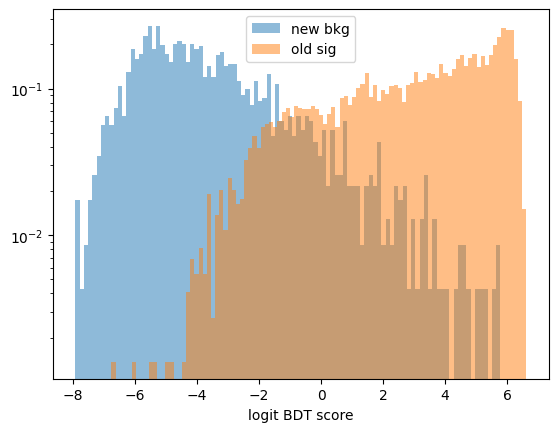

In [84]:
pred_bkg = booster_pred_df(booster, df_bkg_selected)
pred_sig = booster_pred_df(booster, df_sig_selected)

bkg_arr = np.array(pred_bkg)
sig_arr = np.array(pred_sig)

logit_bkg = np.log(bkg_arr/(1-bkg_arr))
logit_sig = np.log(sig_arr/(1-sig_arr))

plt.hist(logit_bkg, bins=100, alpha=0.5, label='new bkg', density=True)
plt.hist(logit_sig, bins=100, alpha=0.5, label='old sig',density=True)
plt.yscale('log')
plt.xlabel('logit BDT score')
plt.legend()
plt.show()